# Train a scVI model using multiGPU

In this simple tutorial, we will show hot to train an scvi-tools model using multiGPU.

SCVI-Tools v1.3.0 now support training on a multi GPU system, which can significantly speed up training and allow you to handle larger datasets. It is supported only on Nvidia GPUs and DDP with CUDA backend.

We will start by downloading sample dataset and perform the standrad preprocessing

In [1]:
import tempfile

import scanpy as sc
import scvi
import seaborn as sns
import torch
from scvi.model import SCVI

→ connected lamindb: anonymous/lamindb_collection


In [2]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.3.2


In [3]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

In [4]:
adata = scvi.data.heart_cell_atlas_subsampled(save_path=".")

INFO     File ./hca_subsampled_20k.h5ad already downloaded                                                         


In [5]:
sc.pp.filter_genes(adata, min_counts=3)

In [6]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

In [7]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="cell_source",
)

In [8]:
adata

AnnData object with n_obs × n_vars = 18641 × 1200
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'cell_type_colors', 'log1p', 'hvg'
    layers: 'counts'

In [9]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["cell_source", "donor"],
    continuous_covariate_keys=["percent_mito", "percent_ribo"],
)

Lets compare the runtime of a single vs multigpu (X2) train for this small dataset (2 sessions of ddp cant be run in same session so we present the result of running single GPU here)

In [10]:
# model_no_multigpu = SCVI(adata)

In [11]:
# import time
# print("Single GPU SCVI train")
# start = time.time()
# model_no_multigpu.train(
#    max_epochs=100,
#    check_val_every_n_epoch=1,
# )
# print("done")
# end = time.time()
# print(f"Elapsed time: {end - start:.2f} seconds")
# Elapsed time: 62.12 seconds

In [12]:
model = SCVI(adata)

Here we will set specific parameters (accelerator, devices and strategy) to be able to run this tutorial in an interactive environment such as jupyter or colab notebooks

In [13]:
datasplitter_kwargs = {}
datasplitter_kwargs["drop_dataset_tail"] = True
datasplitter_kwargs["drop_last"] = False

In [15]:
import time

print("multi GPU SCVI train")
start2 = time.time()
model.train(
    max_epochs=100,
    check_val_every_n_epoch=1,
    accelerator="gpu",
    devices=-1,
    datasplitter_kwargs=datasplitter_kwargs,
    strategy="ddp_notebook_find_unused_parameters_true",
)
print("done")
end2 = time.time()
print(f"Elapsed time: {end2 - start2:.2f} seconds")

/home/access/miniconda3/lib/python3.12/site-packages/scvi/train/_trainrunner.py:81: UserWarning: early_stopping was automaticaly disabled due to the use of DDP
  self.trainer = self._trainer_cls(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


multi GPU SCVI train


Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1]
/home/access/miniconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/access/miniconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 

Training:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


done
Elapsed time: 40.88 seconds


In [16]:
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False

In [17]:
assert model.is_trained

Model was trained and as can be seen faster than the single GPU version. If the data was larger we would have seen this gap increase.
We will continue the down stream analysis in the same manner as was previously done in other tutorials (get the latent representation, save and load the model and plot umaps of the embeddings.

In [18]:
SCVI_LATENT_KEY = "X_scVI"
latent = model.get_latent_representation()
adata.obsm[SCVI_LATENT_KEY] = latent
latent.shape

(18641, 10)

In [19]:
model.save("scvi_model", overwrite=True)

In [20]:
model = scvi.model.SCVI.load("scvi_model", adata=adata)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File scvi_model/model.pt already downloaded                                                               


In [21]:
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False

In [22]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata, min_dist=0.3)

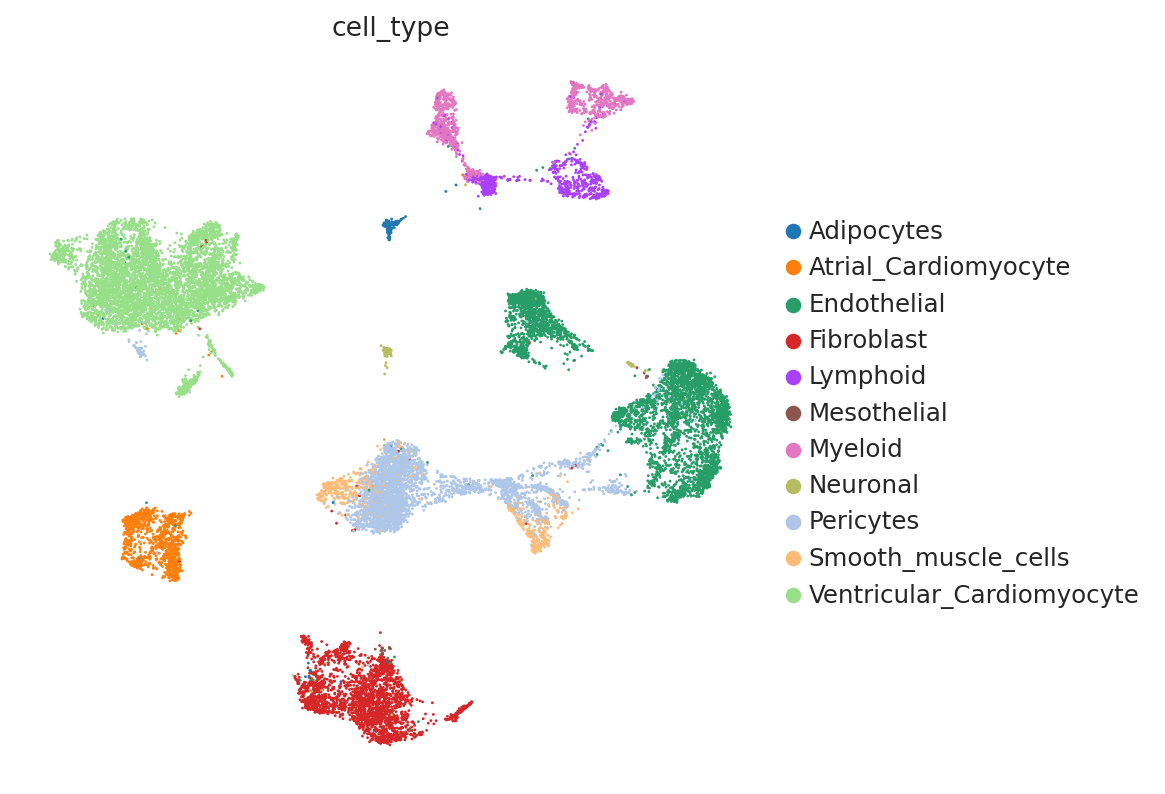

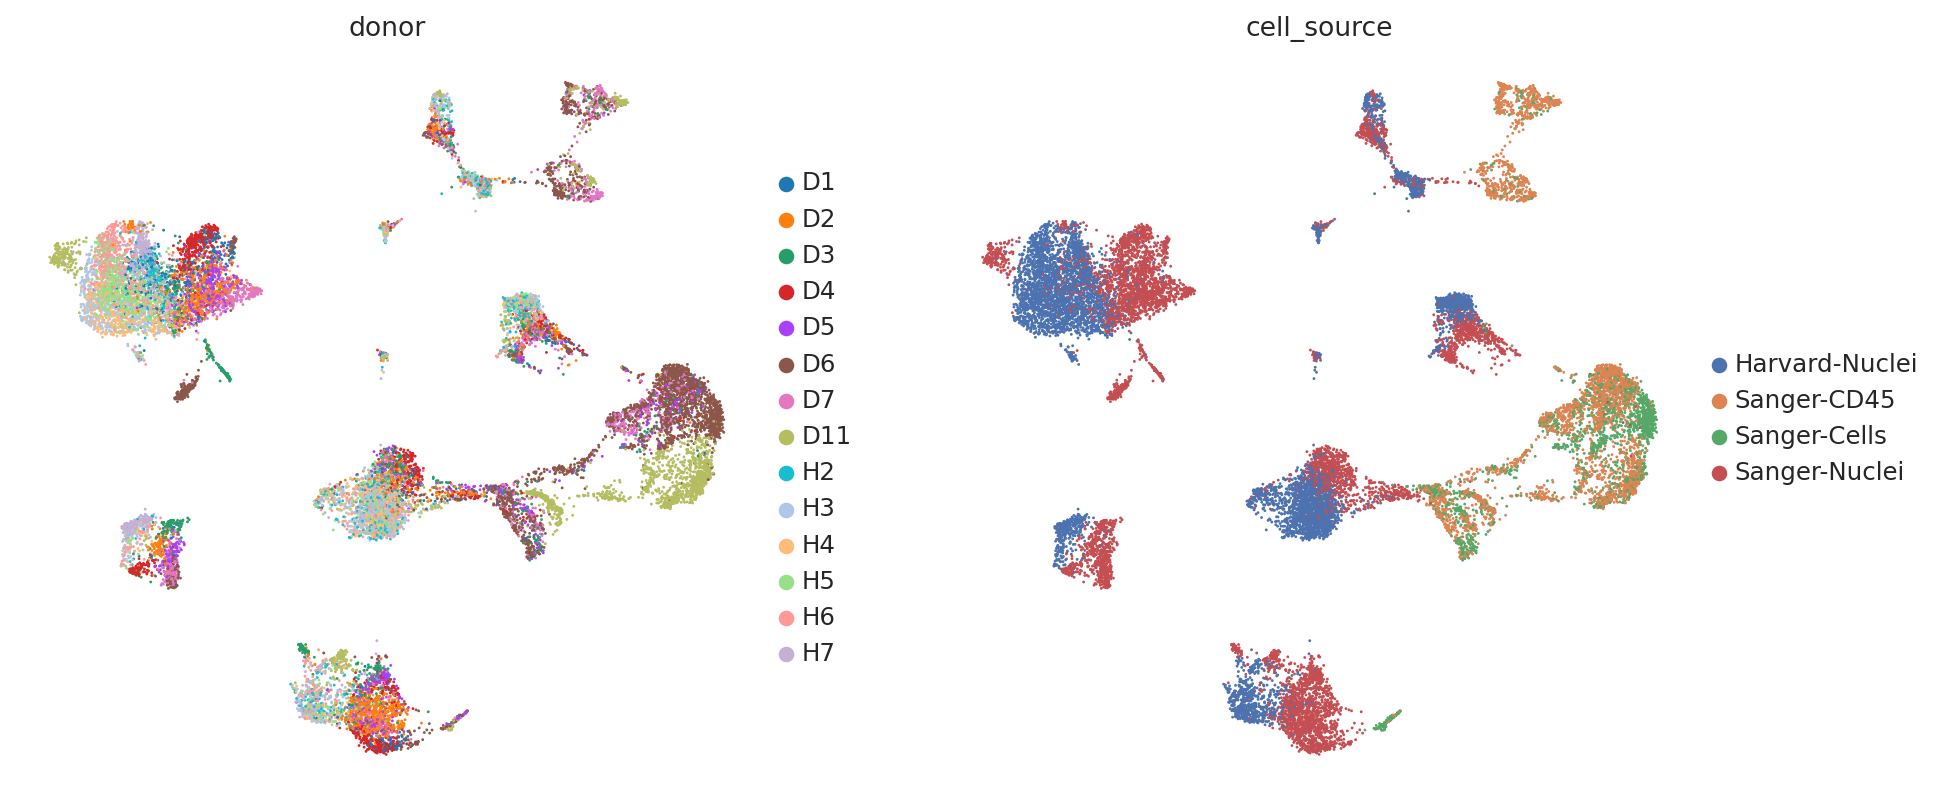

In [23]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)

In [24]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata, min_dist=0.3)

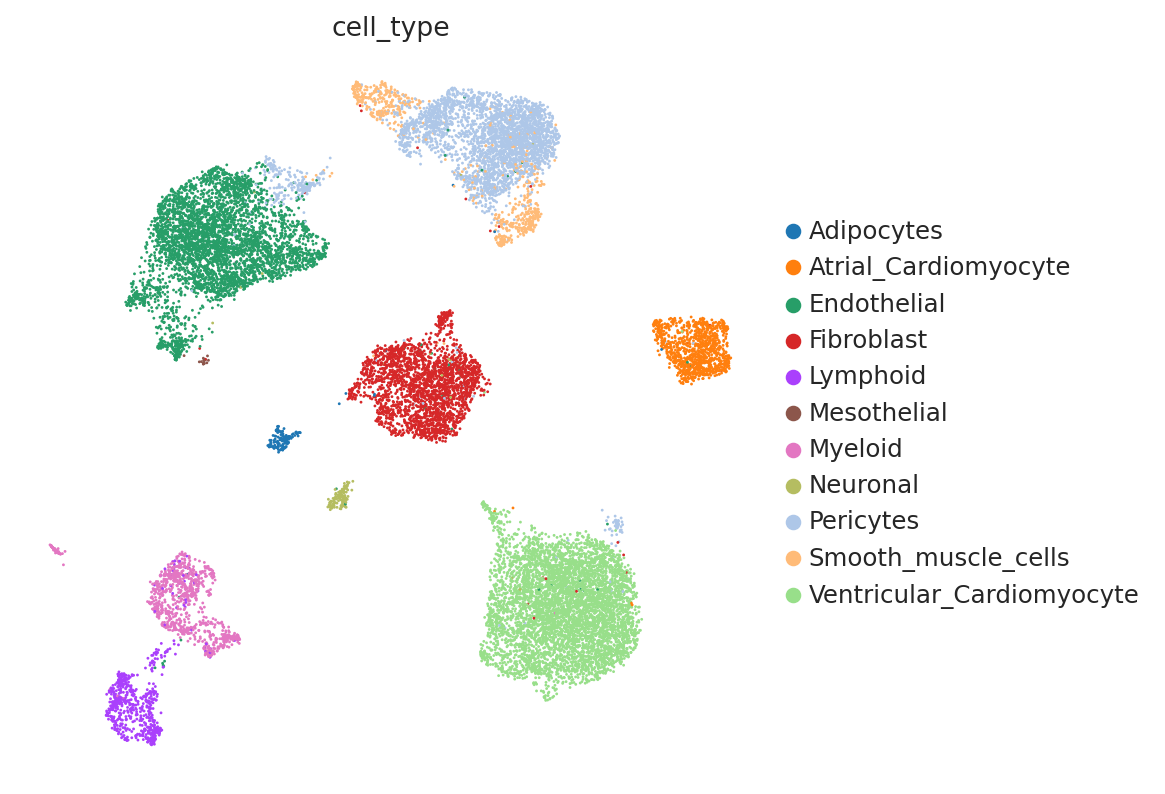

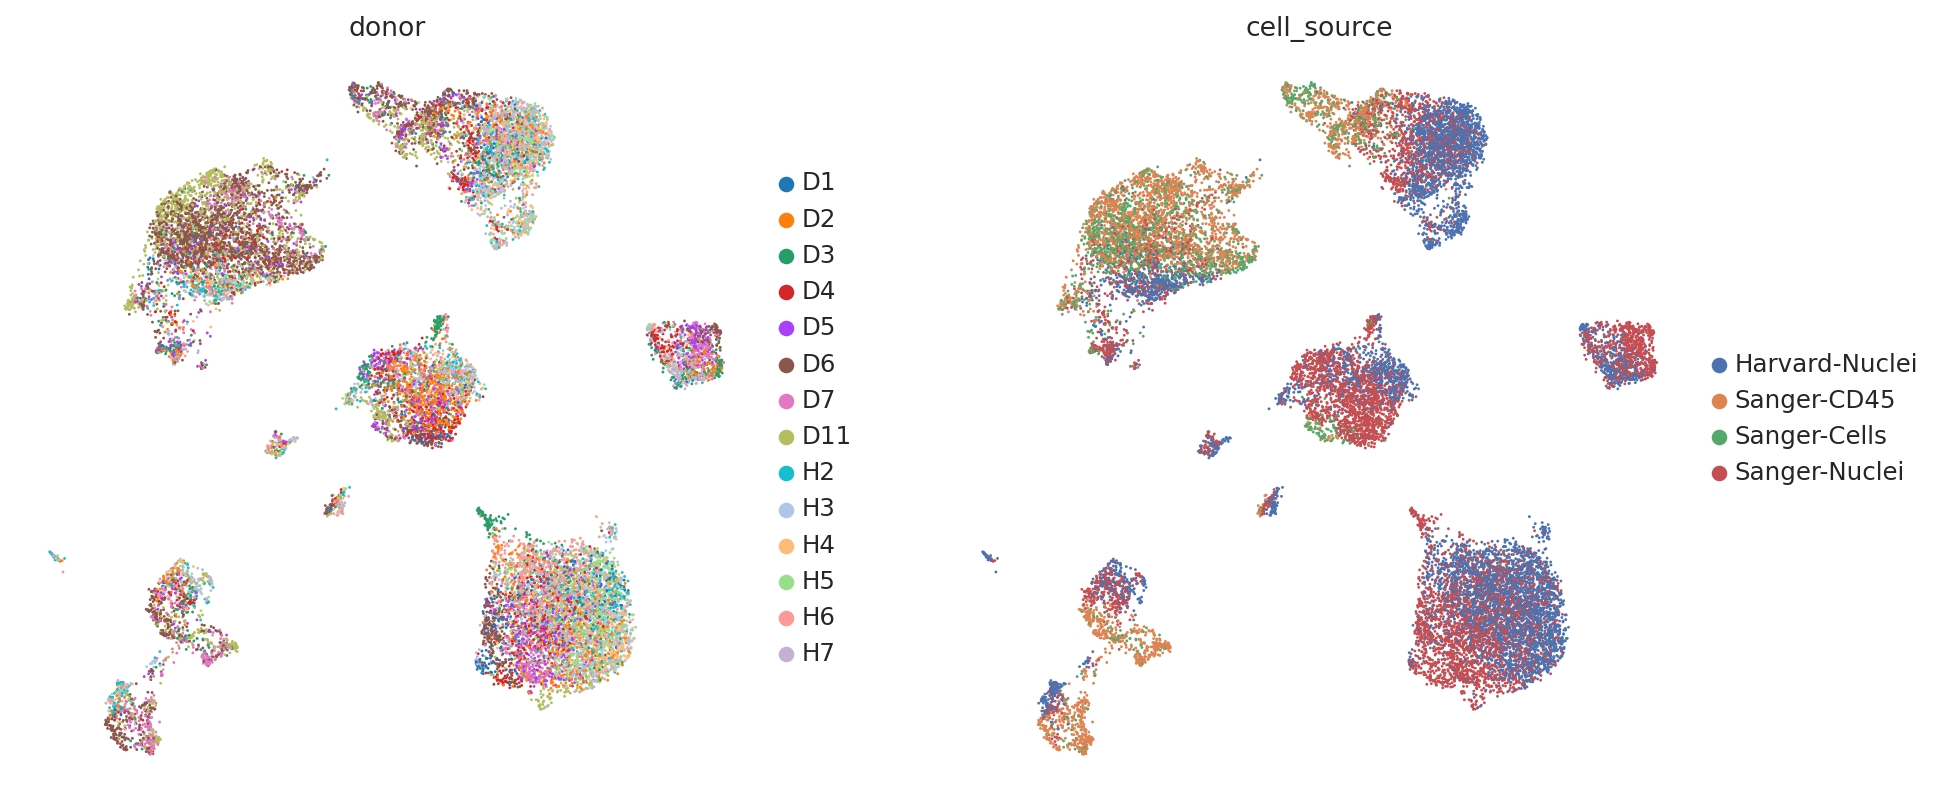

In [25]:
sc.pl.umap(
    adata,
    color=["cell_type"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["donor", "cell_source"],
    ncols=2,
    frameon=False,
)

In [26]:
# neighbors were already computed using scVI
SCVI_CLUSTERS_KEY = "leiden_scVI"
sc.tl.leiden(adata, key_added=SCVI_CLUSTERS_KEY, resolution=0.5)

/tmp/ipykernel_15142/3580189653.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added=SCVI_CLUSTERS_KEY, resolution=0.5)


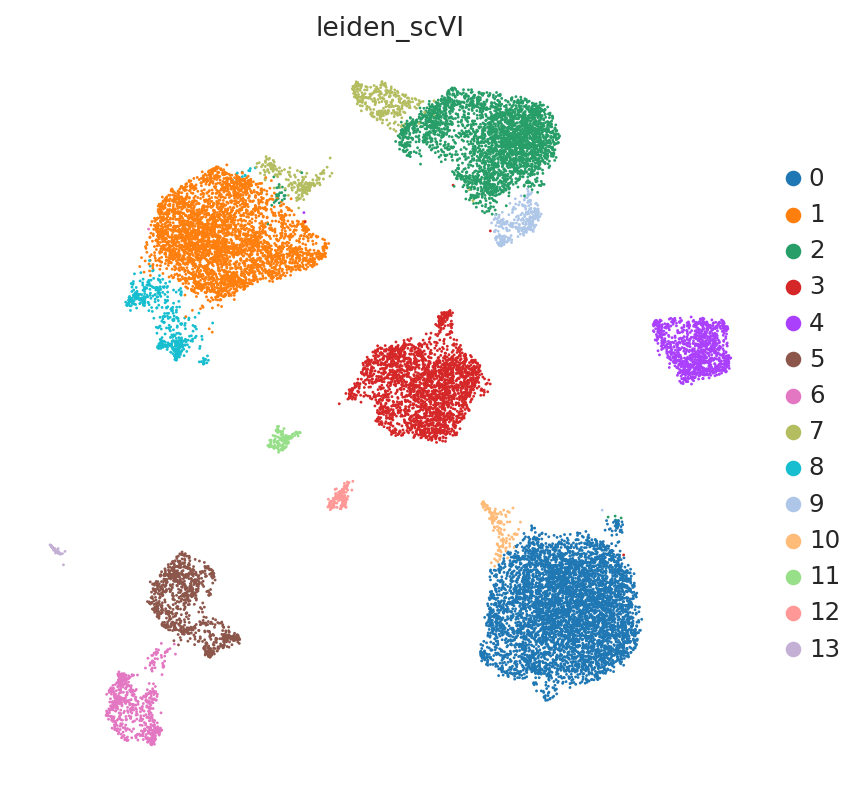

In [27]:
sc.pl.umap(
    adata,
    color=[SCVI_CLUSTERS_KEY],
    frameon=False,
)